In [ ]:
!pip install torchmetrics -U mlxtend

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 761.3/761.3 kB 7.0 MB/s eta 0:00:00


In [ ]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.0.1+cu118
torchvision version: 0.15.2+cu118


In [ ]:
import os
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
import tarfile
from torchvision import datasets, models
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.utils.data.dataloader import DataLoader
from torch import nn
from torchvision import  transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from tqdm.auto import tqdm
import time
from tempfile import TemporaryDirectory

In [ ]:
from timeit import default_timer as timer
 from torch.types import Device

In [ ]:
# Continue with regular imports


# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary


[INFO] Couldn't find torchinfo... installing it.


In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
#transform for train and val data
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

#Get the data

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Define data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Download and save CIFAR-10 dataset
data_dir = './cifar10_data'
os.makedirs(data_dir, exist_ok=True)

# Specify train and val sizes
train_size = 45000
val_size = 5000

# Load original dataset
full_dataset = datasets.CIFAR10(data_dir, train=True, download=True)

# Split dataset into train and val based on specified sizes
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

# Apply transformations to train and val datasets
train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val']

# Create dataloaders
dataloaders = {
    'train': torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True),
    'val': torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
}
# get test data
test_dir = datasets.CIFAR10(data_dir, train=False, download=True, transform=manual_transforms)
test_dataloader = DataLoader(test_dir, batch_size=64, shuffle=False)


# Get dataset sizes and class names
dataset_sizes = {x: len(dataloader.dataset) for x, dataloader in dataloaders.items()}
class_names = full_dataset.classes

# Set device to cuda if available, else CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


100%|██████████| 170498071/170498071 [00:02<00:00, 71468649.77it/s]


Extracting ./cifar10_data/cifar-10-python.tar.gz to ./cifar10_data
Files already downloaded and verified


In [ ]:
len(test_dir), class_names

(10000,
 ['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'])

#Plot and view images

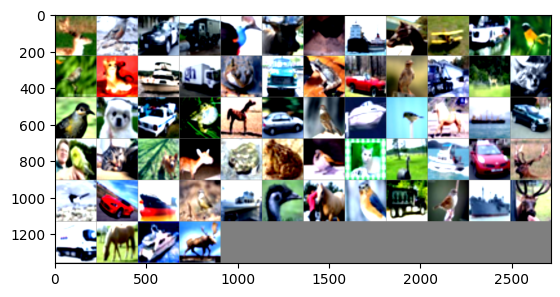

deer  bird  automobile truck bird  deer  cat   ship  horse airplane ship  bird  bird  dog   ship  truck frog  automobile frog  automobile bird  truck deer  cat   bird  dog   automobile frog  horse automobile bird  ship  bird  horse ship  automobile bird  cat   dog   deer  frog  frog  bird  cat   bird  ship  automobile deer  bird  automobile ship  bird  ship  bird  horse bird  truck bird  ship  deer  truck horse ship  deer 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
batch_size =64

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(dataloaders["train"])
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images, nrow=12))
# print labels
print(' '.join(f'{class_names[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
from torchvision.utils import make_grid

def show_batch(dataloader):
  for images, labels in dataloader:
    fig, ax = plt.subplots(figsize=(12,6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1,2,0))
    break

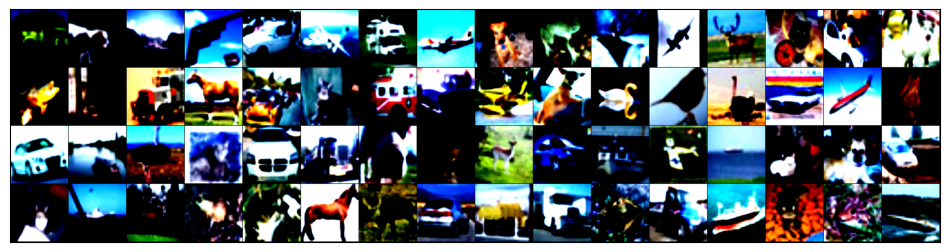

In [ ]:
show_batch(dataloaders["val"])

#**Initialize pretrained model and print the model summary**

In [ ]:
model_pretrained = models.resnet18(weights='IMAGENET1K_V1')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 195MB/s]


In [ ]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model_pretrained,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 1000]           --                   True
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   True
│    └─BasicBlock (0)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   True
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     36,864               True
│    │    └─BatchN

#**Function to train the model**

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

#**Finetuning the ConvNet**

Instead of random weight initialization, we initialize the network with pretrained weights from the pretrained model.

In [ ]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 10)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model_ft,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 10]             --                   True
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   True
│    └─BasicBlock (0)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   True
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     36,864               True
│    │    └─BatchN

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 0.5010 Acc: 0.8430
val Loss: 0.2134 Acc: 0.9306

Epoch 1/9
----------
train Loss: 0.1790 Acc: 0.9416
val Loss: 0.1680 Acc: 0.9460

Epoch 2/9
----------
train Loss: 0.1065 Acc: 0.9665
val Loss: 0.1535 Acc: 0.9462

Epoch 3/9
----------
train Loss: 0.0653 Acc: 0.9821
val Loss: 0.1493 Acc: 0.9506

Epoch 4/9
----------
train Loss: 0.0394 Acc: 0.9904
val Loss: 0.1542 Acc: 0.9522

Epoch 5/9
----------
train Loss: 0.0258 Acc: 0.9953
val Loss: 0.1506 Acc: 0.9546

Epoch 6/9
----------
train Loss: 0.0187 Acc: 0.9972
val Loss: 0.1554 Acc: 0.9516

Epoch 7/9
----------
train Loss: 0.0108 Acc: 0.9994
val Loss: 0.1569 Acc: 0.9516

Epoch 8/9
----------
train Loss: 0.0100 Acc: 0.9995
val Loss: 0.1510 Acc: 0.9544

Epoch 9/9
----------
train Loss: 0.0095 Acc: 0.9994
val Loss: 0.1567 Acc: 0.9522

Training complete in 38m 3s
Best val Acc: 0.954600


#**Evaluate the model performance on the test data**

In [ ]:
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
    """Returns a dictionary containing the results of model predicting on data_loader."""
    loss, acc, correct = 0, 0, 0
    model.eval()  # Use the provided model argument instead of cnn_model
    with torch.inference_mode():
        for i, data in enumerate(data_loader):
          X, y = data[0].to(device), data[1].to(device)
          # Make predictions
          y_pred = model(X)  # Use the provided model argument

          # Accumulate the loss and acc values per batch
          loss += loss_fn(y_pred, y)
          acc += accuracy_fn(y_true=y,
                            y_pred=y_pred.argmax(dim=1))
          correct += torch.eq(y, y_pred.argmax(dim=1)).sum().item()

        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"corret_predictions": correct,
            "model_loss": loss.item(),
            "model_acc": acc}  # Convert to item

# Calculate model results on test dataset
model_results = eval_model(model=model_ft,
                            data_loader=test_dataloader,
                            loss_fn=criterion,
                            accuracy_fn=accuracy_fn)
model_results


{'corret_predictions': 9451,
 'model_loss': 0.1730818748474121,
 'model_acc': 94.50636942675159}

In [ ]:
len(test_dataloader)

157

#**Data Augmentation:**
##**Transform the data and test the model's performance on the transformed data**


#####**Define a custom transformation to add Gaussian noise**

In [ ]:
import numpy as np
from PIL import Image

class AddGaussianNoise:
    def __init__(self, mean=0, std=1, p=0.5):
        self.mean = mean
        self.std = std
        self.p = p

    def __call__(self, img):
        if np.random.rand() < self.p:
            img_np = np.array(img)
            noise = np.random.normal(self.mean, self.std, img_np.shape)
            noisy_img = np.clip(img_np + noise, 0, 255).astype(np.uint8)
            return Image.fromarray(noisy_img)
        return img

#####**Initializing other Augmentation Transformations**

In [ ]:
data_transforms = {
    'colorjitter': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'random_perspective': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomPerspective(distortion_scale=0.5, p=0.8),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'random_affine': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomAffine(degrees=0, shear=20),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'random_rotation': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomRotation(degrees=30),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'Gaussian_Noise' : transforms.Compose([
        transforms.Resize((224, 224)),
        AddGaussianNoise(mean=0, std=25, p=0.5),  # Add Gaussian noise with mean 0, std 25, probability 0.5
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
    ])
}




##**Get and transform the data**




In [ ]:
torch.manual_seed = 42
torch.cuda.manual_seed(42)

aug_test_dir = {x:datasets.CIFAR10(data_dir, train=False, download=True, transform=data_transforms[x])
                  for x in ['colorjitter', 'random_perspective', 'random_affine', 'random_rotation', 'Gaussian_Noise']}

aug_test_dataloader = {x:DataLoader(aug_test_dir[x], batch_size=64, shuffle=False)
                  for x in ['colorjitter', 'random_perspective', 'random_affine', 'random_rotation', 'Gaussian_Noise']}


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
len(aug_test_dataloader["random_perspective"])

157

###**Plot and view the augmented data**

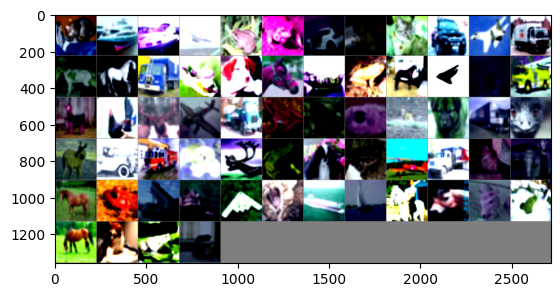

cat   ship  ship  airplane frog  frog  automobile frog  cat   automobile airplane truck dog   horse truck ship  dog   horse ship  frog  horse airplane deer  truck dog   bird  deer  airplane truck frog  frog  dog   deer  dog   truck bird  deer  automobile truck dog   deer  frog  dog   frog  airplane truck cat   truck horse frog  truck ship  airplane cat   ship  ship  horse horse deer  frog  horse cat   frog  cat  


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
batch_size =64

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(aug_test_dataloader["colorjitter"])
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images, nrow=12))
# print labels
print(' '.join(f'{class_names[labels[j]]:5s}' for j in range(batch_size)))

#**Evaluate and make predictions on the augmented data**

In [ ]:
def get_all_preds(model, dataloader, loss_fn: torch.nn.Module, device: torch.device = device):
    pred_probs = []
    labels_list = []  # Create a list to store labels
    model.to(device)
    loss, acc, correct = 0, 0, 0
    model.eval()

    with torch.no_grad():  # Using no_grad context to avoid unnecessary gradient calculations
        for batch in dataloader:
            images, batch_labels = batch  # Use a different variable name for the labels
            images, batch_labels = images.to(device), batch_labels.to(device)

            pred_logit = model(images)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = pred_logit.argmax(dim=1)

            # Get pred_prob off the GPU for further calculations
            pred_probs.append(pred_prob)
            labels_list.append(batch_labels)  # Store the labels in a list

            loss += loss_fn(pred_logit, batch_labels)  # Use batch_labels for loss calculation
            acc += accuracy_fn(y_true=batch_labels, y_pred=pred_logit.argmax(dim=1))
            correct += torch.eq(batch_labels, pred_logit.argmax(dim=1)).sum().item()

        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(dataloader)
        acc /= len(dataloader)

    # Convert to item
    pred_probs = torch.cat(pred_probs, dim=0)
    labels = torch.cat(labels_list, dim=0)  # Concatenate the list of labels into a tensor
    return {
        "pred_probs": pred_probs,
        "labels":labels,
        "model_result":{"correct_predictions": correct,
        "model_loss": loss.item(),
        "model_acc": acc}
    }

pred_labels = {x: get_all_preds(model=model_ft, loss_fn=criterion, dataloader=aug_test_dataloader[x], device=device)
               for x in ['colorjitter', 'random_perspective', 'random_affine', 'random_rotation', 'Gaussian_Noise']}




###**Model Accuracy**

In [ ]:
aug_accuracy = {x: accuracy_fn(y_true=pred_labels[x]["labels"], y_pred=pred_labels[x]["pred_probs"])
                for x in ['colorjitter', 'random_perspective', 'random_affine', 'random_rotation', 'Gaussian_Noise']}


In [ ]:
pred_labels["random_affine"]

{'pred_probs': tensor([3, 8, 8,  ..., 5, 1, 7], device='cuda:0'),
 'labels': tensor([3, 8, 8,  ..., 5, 1, 7], device='cuda:0'),
 'model_result': {'correct_predictions': 8656,
  'model_loss': 0.44978639483451843,
  'model_acc': 86.59434713375796}}

###**Compare actual test data accuracy and Augmented data accuracy**

In [ ]:
#DataFrame with number of correct predictions
import pandas as pd

data_accuracies = {
    'actual_test_data': model_results,
    'colorjitter': pred_labels["colorjitter"]["model_result"],
    'random_perspective': pred_labels["random_perspective"]["model_result"],
    'random_affine': pred_labels["random_affine"]["model_result"],
    'random_rotation': pred_labels["random_rotation"]["model_result"],
    'Gaussian_Noise': pred_labels["Gaussian_Noise"]["model_result"]
}

# Create a DataFrame from the dictionary
df = pd.DataFrame(data_accuracies.items(), columns=['Data', 'Accuracy'])

# Display the DataFrame
df


,Data,Accuracy
0,actual_test_data,"{'corret_predictions': 9451, 'model_loss': 0.1..."
1,colorjitter,"{'correct_predictions': 8821, 'model_loss': 0...."
2,random_perspective,"{'correct_predictions': 7896, 'model_loss': 0...."
3,random_affine,"{'correct_predictions': 8656, 'model_loss': 0...."
4,random_rotation,"{'correct_predictions': 8314, 'model_loss': 0...."
5,Gaussian_Noise,"{'correct_predictions': 7209, 'model_loss': 1...."


In [ ]:
import pandas as pd

data_accuracies = [
    model_results,
    pred_labels["colorjitter"]["model_result"],
    pred_labels["random_perspective"]["model_result"],
    pred_labels["random_affine"]["model_result"],
    pred_labels["random_rotation"]["model_result"],
    pred_labels["Gaussian_Noise"]["model_result"]
]

index = ['actual_test_data', 'colorjitter', 'random_perspective', 'random_affine', 'random_rotation', 'Gaussian_Noise']
columns = model_results.keys()  # Assuming model_results is a dictionary containing keys for the columns

df = pd.DataFrame(data_accuracies, index=index, columns=columns)
df.drop("corret_predictions",axis=1,inplace=True)
df


,model_loss,model_acc
actual_test_data,0.173082,94.506369
colorjitter,0.410594,88.146895
random_perspective,0.723925,78.911226
random_affine,0.449786,86.594347
random_rotation,0.551724,83.130971
Gaussian_Noise,1.004565,72.074045


##**Compute Confusion Metrix**

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

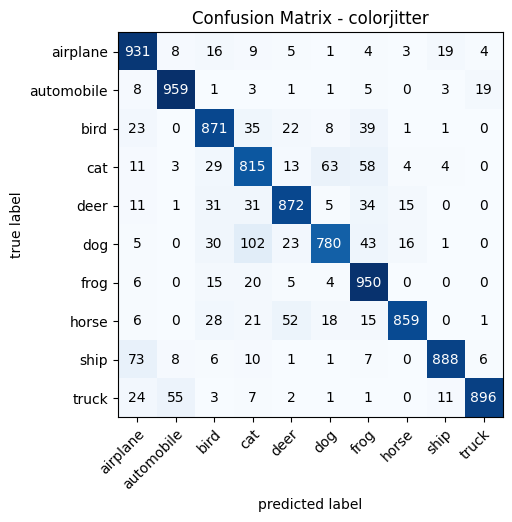

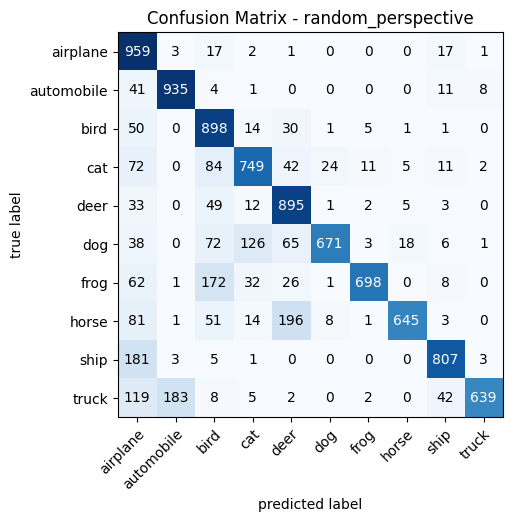

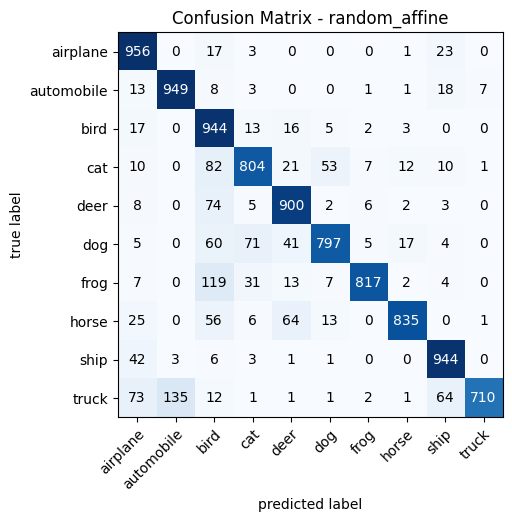

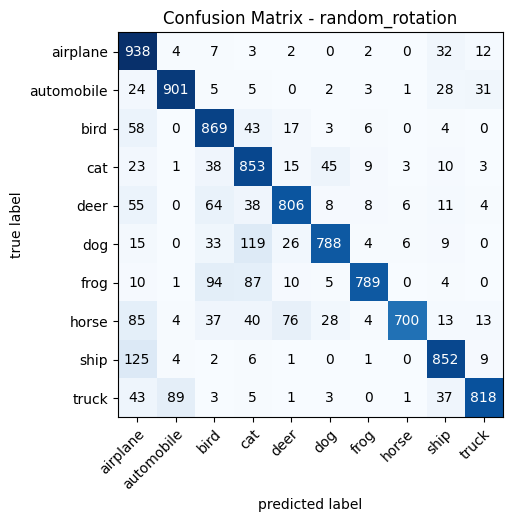

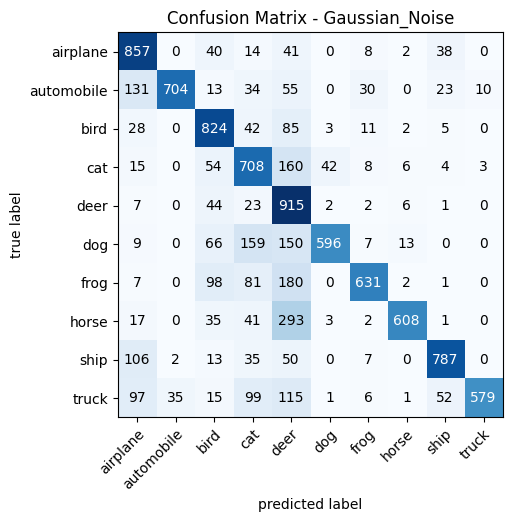

In [ ]:
confmat = ConfusionMatrix(num_classes=len(class_names), task="MULTICLASS").to(device)
confmat_tensor = {x: confmat(preds=pred_labels[x]["pred_probs"], target=pred_labels[x]["labels"])
                  for x in ['colorjitter', 'random_perspective', 'random_affine', 'random_rotation', 'Gaussian_Noise']}




for x in ['colorjitter', 'random_perspective', 'random_affine', 'random_rotation', 'Gaussian_Noise']:
  fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor[x].cpu().numpy(),
    class_names=class_names,
    figsize=(5, 5)
  )
  ax.set_title(f'Confusion Matrix - {x}')